In [81]:
import numpy as np

rng = np.random.default_rng(0)

In [82]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

In [83]:
def your_data_utils(x):
    ''' Здесь придумайте какой-нибудь свой пример с данными по аналогии с гауссинками и проверьте алгоритмы на них '''
    d = len(x)
    scales = np.linspace(1.0, 3.0, d)
    R = np.eye(d)
    if d >= 2:
        theta = np.deg2rad(15)
        R[:2, :2] = [
            [np.cos(theta), -np.sin(theta)], 
            [np.sin(theta),  np.cos(theta)]
        ]

    def fwd(z):
        return R @ (scales * z) # поворот + масштабирование

    def inv(y):
        return (R.T @ y) / scales

    return fwd, inv

In [84]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [85]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [86]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    '''
    y = x + 0.5 * step^2 * grad_logp(x) + step * N(0,I)
    a = min(1, exp(logp(y) - logp(x) + log q(y>x) - log q(x>y)))
    log q(a>b) = -0.5 / step^2 * l2(b - mu_a) (+c)
    '''
    
    x = x0.copy()
    d = len(x)
    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        grad_x = grad_logp(x)
        mu_x = x + 0.5 * (step**2) * grad_x
        z = rng.normal(0, 1, size=d)
        y = mu_x + step * z

        grad_y = grad_logp(y)
        mu_y = y + 0.5 * (step**2) * grad_y

        log_q_xy = -0.5 / (step**2) * np.dot(y - mu_x, y - mu_x)
        log_q_yx = -0.5 / (step**2) * np.dot(x - mu_y, x - mu_y)

        log_alpha = logp(y) - logp(x) + log_q_yx - log_q_xy

        if np.log(rng.uniform()) < log_alpha:
            x = y
            accept += 1

        chain[t] = x

    return chain, accept / steps

In [87]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

# mala_step = 0.3 # тут попробуйте подобрать хороший шаг
# mh_scale = 0.8 # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

In [88]:
# https://www.math.pku.edu.cn/teachers/xirb/Courses/QR2013/ReadingForFinal/MCMC/euclid.ss.1015346320.pdf

def qtune_mh(x0, candidates, pilot_steps=200):
    best = (None, 1e9)
    target = 0.234
    for s in candidates:
        _, acc = mh(x0, pilot_steps, s)
        if abs(acc - target) < best[1]:
            best = (s, abs(acc - target))
    return best[0]

def qtune_mala(x0, candidates, pilot_steps=200):
    best = (None, 1e9)
    target = 0.574
    for st in candidates:
        _, acc = mala(x0, pilot_steps, st)
        if abs(acc - target) < best[1]:
            best = (st, abs(acc - target))
    return best[0]

mala_step = qtune_mala(x0, np.logspace(-2, -0.3, 8), pilot_steps=500)
mh_scale = qtune_mh(x0, np.logspace(-2, 0.3, 8), pilot_steps=500)

In [89]:
mala_step, mh_scale

(0.5011872336272722, 0.9363292088239417)

In [90]:
mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

In [91]:
# Выведите снизу acceptance rate и медианный ESS по размерности d для MH и MALA. Не забудьте обрезать burn-in!
mh_samples = mh_chain[burn:]
mala_samples = mala_chain[burn:]

mh_ess = np.array([ess(mh_samples[:, i]) for i in range(d)])
mala_ess = np.array([ess(mala_samples[:, i]) for i in range(d)])

In [92]:
print(f'{mh_acc=}')
print(f'{mala_acc=}')
print(f'{np.median(mh_ess)=}')
print(f'{np.median(mala_ess)=}')

mh_acc=0.16986666666666667
mala_acc=0.9596333333333333
np.median(mh_ess)=769.9444198122228
np.median(mala_ess)=1695.7148813808433


In [93]:
import pandas as pd

pd.DataFrame({
    'dim': np.arange(d),
    'mh_ess': np.round(mh_ess, 1),
    'mala_ess': np.round(mala_ess, 1)
})

,dim,mh_ess,mala_ess
0,0,741.9,1327.1
1,1,663.7,1945.4
2,2,836.6,1701.8
3,3,810.7,1754.4
4,4,767.3,1510.3
5,5,772.6,1748.1
6,6,835.2,1659.7
7,7,883.7,2446.7
8,8,635.6,1689.7
9,9,751.6,1657.6


In [94]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)
import matplotlib.pyplot as plt

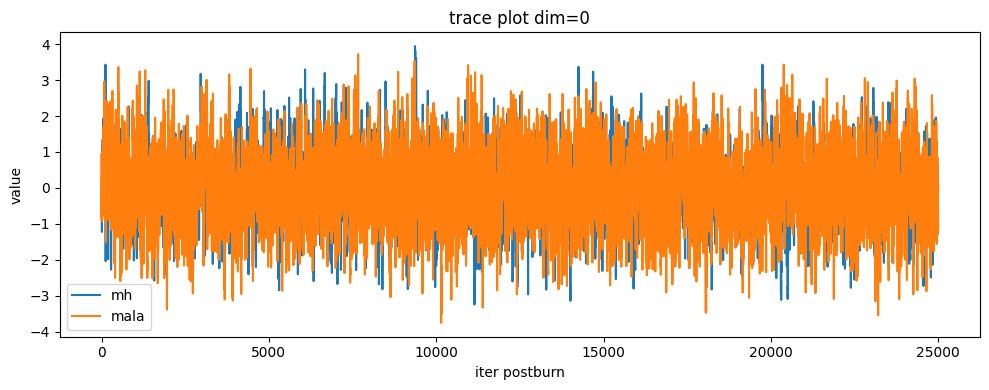

In [95]:
dim = 0

plt.figure(figsize=(10,4))
plt.plot(mh_samples[:, dim], label='mh')
plt.plot(mala_samples[:, dim], label='mala')
plt.title(f'trace plot {dim=}')
plt.xlabel('iter postburn')
plt.ylabel('value')
plt.legend()
plt.tight_layout()
plt.show()

In [96]:
def acf_series(x, max_lag=200):
    x = x - x.mean()
    acf_full = np.correlate(x, x, mode='full')
    acf = acf_full[len(acf_full)//2:len(acf_full)//2 + max_lag + 1]
    acf = acf / acf[0]
    return acf

max_lag = 100
acf_mh = acf_series(mh_samples[:, dim], max_lag=max_lag)
acf_mala = acf_series(mala_samples[:, dim], max_lag=max_lag)

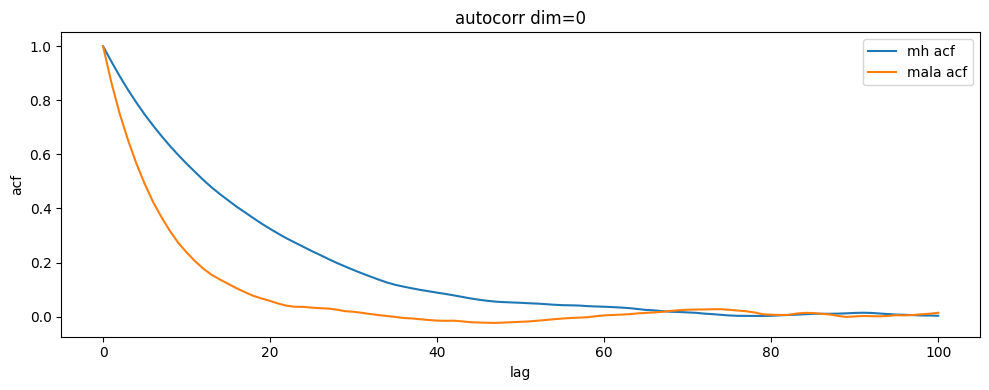

In [97]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(acf_mh)), acf_mh, label='mh acf')
plt.plot(np.arange(len(acf_mala)), acf_mala, label='mala acf')
plt.title(f'autocorr {dim=}')
plt.xlabel('lag')
plt.ylabel('acf')
plt.legend()
plt.tight_layout()
plt.show()

In [98]:
# mala сходится быстрее mh

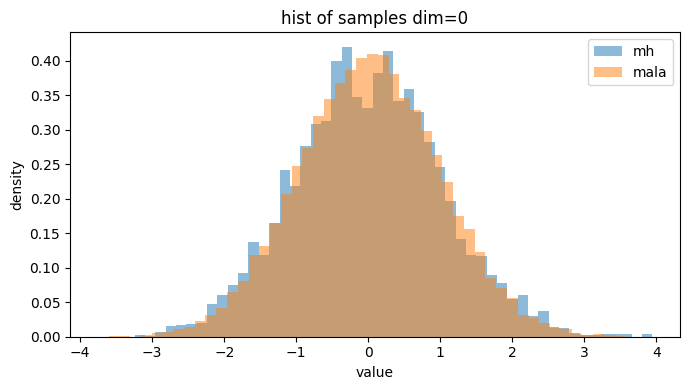

In [99]:
plt.figure(figsize=(7,4))
plt.hist(mh_samples[:, dim], bins=50, density=True, alpha=0.5, label='mh')
plt.hist(mala_samples[:, dim], bins=50, density=True, alpha=0.5, label='mala')
plt.title(f'hist of samples {dim=}')
plt.xlabel('value')
plt.ylabel('density')
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
# хист почти одинаковый, mala ближе к N(0,I)

In [101]:
fwd, inv = your_data_utils(x0)

In [102]:
logp_base = logp
grad_logp_base = grad_logp

def logp_trans(y):
    z = inv(y)
    scales = np.linspace(1.0, 3.0, len(y))
    logdet = -np.sum(np.log(scales))
    return logp_base(z) + logdet

def grad_logp_trans(y):
    z = inv(y)
    scales = np.linspace(1.0, 3.0, len(y))
    R = np.eye(len(y))
    if len(y) >= 2:
        theta = np.deg2rad(15)
        R[:2, :2] = [
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ]
    J_inv = (R.T / scales)
    grad_z = grad_logp_base(z)
    return J_inv.T @ grad_z

logp = logp_trans
grad_logp = grad_logp_trans

In [103]:
mh_chain_t, mh_acc_t = mh(fwd(x0), steps, scale=mh_scale)
mala_chain_t, mala_acc_t = mala(fwd(x0), steps, step=mala_step)

In [104]:
mh_samples_t = mh_chain_t[burn:]
mala_samples_t = mala_chain_t[burn:]
mh_ess_t = np.array([ess(mh_samples_t[:, i]) for i in range(d)])
mala_ess_t = np.array([ess(mala_samples_t[:, i]) for i in range(d)])

In [105]:
print(f'{mh_acc=}')
print(f'{mala_acc=}')
print(f'{np.median(mh_ess)=}')
print(f'{np.median(mala_ess)=}')

mh_acc=0.16986666666666667
mala_acc=0.9596333333333333
np.median(mh_ess)=769.9444198122228
np.median(mala_ess)=1695.7148813808433


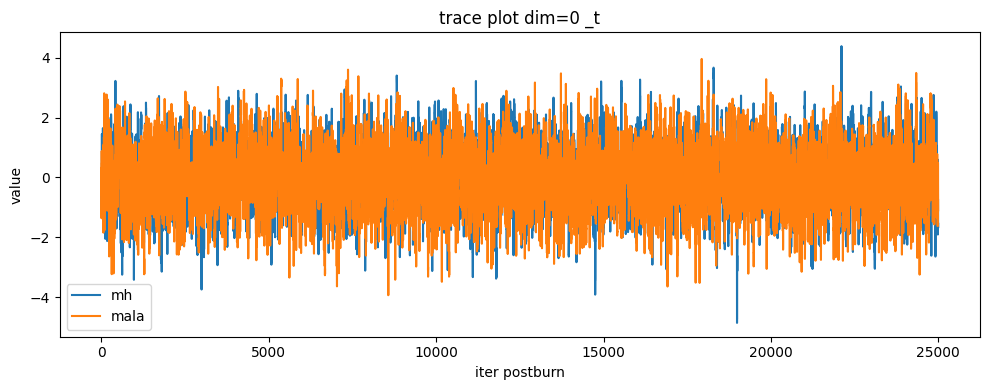

In [106]:
dim = 0

plt.figure(figsize=(10,4))
plt.plot(mh_samples_t[:, dim], label='mh')
plt.plot(mala_samples_t[:, dim], label='mala')
plt.title(f'trace plot {dim=} _t')
plt.xlabel('iter postburn')
plt.ylabel('value')
plt.legend()
plt.tight_layout()
plt.show()

In [107]:
max_lag = 100
acf_mh_t = acf_series(mh_samples_t[:, dim], max_lag=max_lag)
acf_mala_t = acf_series(mala_samples_t[:, dim], max_lag=max_lag)

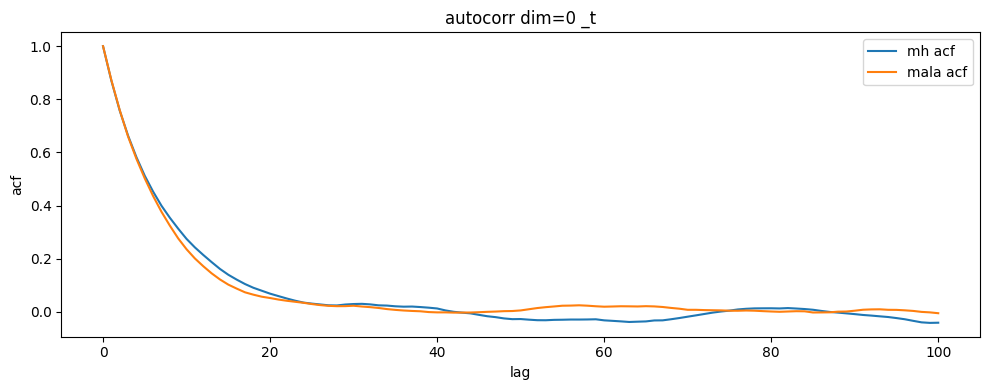

In [108]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(acf_mh_t)), acf_mh_t, label='mh acf')
plt.plot(np.arange(len(acf_mala_t)), acf_mala_t, label='mala acf')
plt.title(f'autocorr {dim=} _t')
plt.xlabel('lag')
plt.ylabel('acf')
plt.legend()
plt.tight_layout()
plt.show()

In [109]:
# тут уже сходятся в целом одинаково

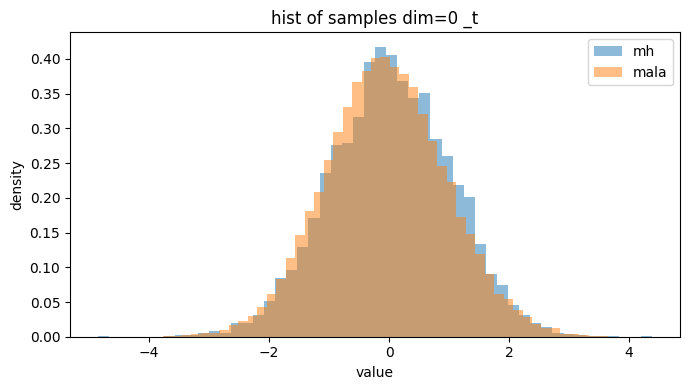

In [110]:
plt.figure(figsize=(7,4))
plt.hist(mh_samples_t[:, dim], bins=50, density=True, alpha=0.5, label='mh')
plt.hist(mala_samples_t[:, dim], bins=50, density=True, alpha=0.5, label='mala')
plt.title(f'hist of samples {dim=} _t')
plt.xlabel('value')
plt.ylabel('density')
plt.legend()
plt.tight_layout()
plt.show()

In [111]:
# хист у mala тут также более похожий на N(0,I), mh чето перекосило ну ниче в пэинте поправим и можно засылать